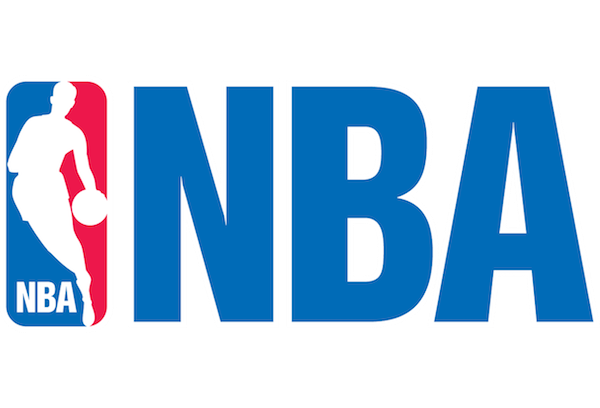

In [4]:
Image(filename='images/logo.png')

In order to appeal to a wider audience, the National Basketball Association (NBA) has turned to analytics to improve its on court product. Cameras installed in the roofs of the arenas and microchips implanted in player’s uniforms track every step and every bounce of the ball. After analyzing the data, teams are altering how the game is played and how teams are organized, resulting in fundamental shifts in strategy and game planning. Numerous studies have been done trying to understand how this data has changed the game. We are going to focus on a few different methods and attempt to correctly forecast winners and losers of games. 

In [15]:
from bs4 import BeautifulSoup
from urllib2 import urlopen
import bs4
import pandas as pd
import pickle
import time
import calendar
import requests
import re
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split
import numpy as np
from Machine_Learning import kristaps
from matplotlib import pyplot as plt


We will start with exploring the data that we are going to utilize for our project. We have collected all games from the beginning of the NBA and have decided to drop all data from more than 20 years ago. We are focusing on the data from when current 30 NBA franchises were established and have been a consistent part of the NBA from that time forward. We also dropped some of the more inconsqeuential columns (season or playoffs games) and duplicated games. 

In [6]:
import pandas as pd
elo = pd.read_csv('data/elo_1946-2015.csv')
elo.head()

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,...,40.294830,NYK,Knicks,68,1300.0000,1306.7233,H,L,0.640065,NaN
1,1,194611010TRH,NBA,1,1947,11/1/1946,1,0,NYK,Knicks,...,41.705170,TRH,Huskies,66,1300.0000,1293.2767,A,W,0.359935,NaN
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,...,42.012257,NYK,Knicks,47,1306.7233,1297.0712,H,W,0.631101,NaN
3,2,194611020CHS,NBA,1,1947,11/2/1946,2,0,NYK,Knicks,...,40.692783,CHS,Stags,63,1300.0000,1309.6521,A,L,0.368899,NaN
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,...,38.864048,WSC,Capitols,50,1300.0000,1320.3811,H,L,0.640065,NaN


Our model was missing about a year and a half of data points that we needed, so we filled in the games that were missing between 2015 and the present day with this data set. It was obtained by scraping NBA reference. This data set needed to be cleaned so that the names for the franchises across our data sets were the same.

In [7]:
recent_data = pd.read_csv('data/recent_data.csv')
recent_data.head()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1
0,"Tue, Oct 27, 2015",8:00 pm,Detroit Pistons,106,Atlanta Hawks,94
1,"Tue, Oct 27, 2015",8:00 pm,Cleveland Cavaliers,95,Chicago Bulls,97
2,"Tue, Oct 27, 2015",10:30 pm,New Orleans Pelicans,95,Golden State Warriors,111
3,"Wed, Oct 28, 2015",7:30 pm,Philadelphia 76ers,95,Boston Celtics,112
4,"Wed, Oct 28, 2015",7:30 pm,Chicago Bulls,115,Brooklyn Nets,100


With the combination of the two previous data sets, we built the historical data set. This contains all the games in the years that we are considering up until the present date. This is the data that we use to calculate our ELO ratings, an important feature in our methods that is explained below.

In [8]:
historical_data = pd.read_csv('data/historical_data.csv')
historical_data.head()

,fran_id,pts,opp_fran,opp_pts,game_location,date
0,Rockets,120,Hawks,104,A,1976-10-21
1,Celtics,129,Pacers,122,A,1976-10-21
2,Clippers,133,Bucks,112,A,1976-10-21
3,Lakers,97,Knicks,102,A,1976-10-21
4,Bulls,95,Cavaliers,106,A,1976-10-22


The ELO rating system is a method for calculating the relative skill levels of players in two-player games such as chess. We have adapted this system in order to measure skill levels of different NBA teams based on their recent performance. We computed the ELO ratings for each team over the history of our dataset, and we use this as a feature.

The difference in the ratings between two players serves as a predictor of the outcome of a match. Two players with equal ratings who play against each other are expected to score an equal number of wins. A player whose rating is 100 points greater than their opponent's is expected to score 64%; if the difference is 200 points, then the expected score for the stronger player is 76%.

A player's Elo rating is represented by a number which increases or decreases depending on the outcome of games between rated players. After every game, the winning player takes points from the losing one. The difference between the ratings of the winner and loser determines the total number of points gained or lost after a game. 

To understand this better, we will look at some visuals.

In [17]:
k = kristaps.Kristaps()
k.train_all(pd.read_csv('data/all_games.csv'),write = 0)

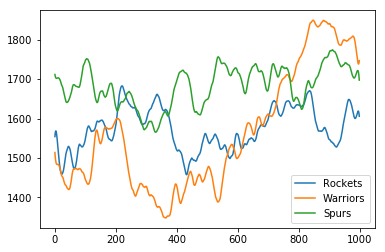

In [20]:
k.plot_Elo(['Rockets', 'Warriors', 'Spurs'], games=1000, window=45, order=5, figsize=None)

This plot tracks the ELO ratings over the last thousand games for the current top three teams in the NBA. We see how ELO shows the rise and falls of how good teams are over long and short terms. In the short term, teams can go on winning streaks and build up momentum, meaning if they are trending upward sharply, it is more likely they will win the very next game. In the long term we see how teams change over time. The yellow line represents the Golden State Warriors, a team that was not very good nearly a decade ago, but has since risen to the top team in the league. Thus ELO provieds a very useful feature in training our models becuase it essentially tells the algorithms if a team is currently 'hot' or trending upward, or if it is the opposite.